In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.cm as cm
from pathlib import Path
import norm
import physconst as pc
from vtk_reader import read_vtk
import ffmpeg as fp

In [2]:
data_dir = Path('/Users/satoukakeru/lab/Jet_Torus/runs')
#run_ids = ['00a', '00a2']
run_ids = ['00a2']
fname = 'accretion_rate.dat'

In [7]:
data_fbase = 'data'
data_type = 'flt'
nc = 128
#ndata = [116, 302]
ndata = [range(300, 302)]
grid = [nc, nc, nc]
nvar = 7
x1_min, x1_max = -5., 5.  # code units
x2_min, x2_max = -5., 5.  # code units
x3_min, x3_max = -5., 5.  # code units
dx1 = (x1_max - x1_min) / grid[0]
dx2 = (x2_max - x2_min) / grid[1]
dx3 = (x3_max - x3_min) / grid[2]
cell_volume = dx1 * dx2 * dx3

do_dens_cut = False

nm = norm.PhysNorm(x=pc.pc, v=pc.c, dens=0.60364*pc.amu, temp=pc.c*pc.c*pc.amu/pc.kboltz, curr=1.)
fnum2year = nm.t / pc.yr * 24.5009005929988

In [8]:
osph = 0.45
x1 = np.linspace(x1_min, x1_max, nc)
x2 = np.linspace(x2_min, x2_max, nc)
x3 = np.linspace(x3_min, x3_max, nc)
x1g, x2g, x3g = np.meshgrid(x1, x2, x3, sparse=True)
r2 = x1g * x1g + x2g * x2g + x3g * x3g

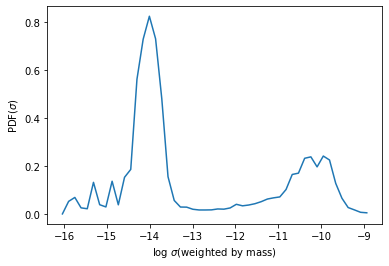

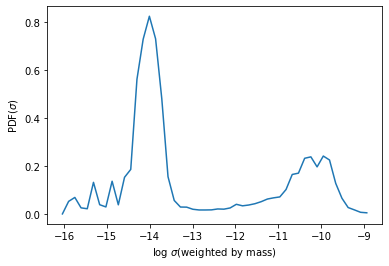

In [14]:
for ir, run_id in enumerate(run_ids):
    for idata in ndata[ir]:
        data_fname = data_dir / run_id / f'{data_fbase}.{idata:0>4d}.{data_type}'

        if data_type == 'flt':
            hydro = np.fromfile(data_fname, dtype=np.float32).reshape((nvar, grid[2], grid[1], grid[0]))
            velocity = hydro[3, :, :, :]
            density = hydro[0, :, :, :]
            density_cut = np.ma.masked_where(r2<osph*osph, density)
            if do_dens_cut:
                density_cut = np.ma.masked_less(density_cut, 1)

        elif data_type == 'vtk':
            with open(data_fname, 'rb') as fp:
                hydro = read_vtk(fp, grid[0], grid[1], grid[2])

        mass = np.sum(density_cut) * cell_volume * nm.m / pc.msun
        z_vel_dis = np.sum(velocity*velocity, axis=0) / grid[2]
        weighted_vel = z_vel_dis * (np.sum(density_cut, axis=2) * dx1 * dx2 * nm.m / pc.msun) / mass
        lvel = np.log10(weighted_vel)

        a = np.histogram(lvel, bins=50, density=True)
        x = (a[1] - ((a[1][1] - a[1][0]) / 2))[1:]
        y = a[0]

        pl.figure()
        pl.plot(x, y)
        pl.xlabel(r'log $\sigma$(weighted by mass)')
        pl.ylabel(r'PDF($\sigma$)')

    time = np.arange(idata+1) * fnum2year